In [15]:
import sys

import matplotlib
import numpy as np
import xarray as xr

sys.path.append("/home/james/git/climate_indices")
from climate_indices import compute, indices, utils

%matplotlib inline

In [2]:
ds = xr.open_dataset("/data/datasets/nclimgrid/nclimgrid_prcp.nc")

In [3]:
precip_var_name = "prcp"

In [4]:
precip = ds[precip_var_name]
print(f"Original shape: {precip.shape}")
precip_data = np.moveaxis(precip.data, 0, -1)
print(f"New data array shape: {precip_data.shape}")

Original shape: (1494, 596, 1385)
New data array shape: (596, 1385, 1494)


In [8]:
scale = 3
sum_scaled_values = np.full(precip_data.shape, np.NaN, dtype=np.float32)
for i in range(precip_data.shape[0]):
    for j in range(precip_data.shape[1]):
        sum_scaled_values[i, j] = compute.sum_to_scale(precip_data[i, j], scale)

In [10]:
precip_data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

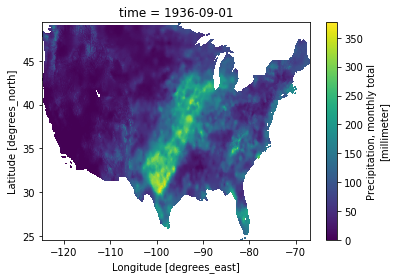

In [16]:
ds[precip_var_name].isel(time=500).plot()

In [23]:
df = pd.read_hdf("/data/datasets/ukbench_quiz/features.hdf5", key="image_id", mode="r")

KeyError: 'No object named image_id in the file'